In [1]:
# EduFit: Adaptive Study Companion - ML Model
# This Jupyter notebook implements the machine learning components of EduFit, including:
# - K-means clustering to identify learning styles
# - Random Forest Classifier to recommend study strategies
# - Study plan generation with curated resources and advice

In [2]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic survey data
survey_data = pd.DataFrame({
    'pref_resource': np.random.choice(['Videos', 'Podcasts', 'Practice', 'Reading'], 50),
    'daily_study_hours': np.random.choice(['Less than 1 hour', '1–2 hours', '2–3 hours', '3–4 hours', 'More than 4 hours'], 50),
    'subject': np.random.choice(['Math', 'Science', 'Other'], 50),
    'preferred_strategy': np.random.choice(['Pomodoro', 'Active Recall', 'Spaced Repetition', 'Note-Taking'], 50)
})

# Save to data/raw
survey_data.to_csv('../data/raw/survey.csv', index=False)
print("Synthetic survey data saved to data/raw/survey.csv")
print(survey_data.head())

Synthetic survey data saved to data/raw/survey.csv
  pref_resource daily_study_hours subject preferred_strategy
0      Practice         2–3 hours    Math  Spaced Repetition
1       Reading         3–4 hours    Math  Spaced Repetition
2        Videos         3–4 hours    Math      Active Recall
3      Practice  Less than 1 hour   Other      Active Recall
4      Practice         2–3 hours    Math        Note-Taking


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load UCI dataset (first 50 records)
uci_data = pd.read_csv('../data/raw/student-mat.csv', sep=';')
uci_data = uci_data[['studytime', 'absences']].head(50)

# Handle missing values
uci_data.fillna(uci_data.mean(), inplace=True)

# Load survey data
survey_data = pd.read_csv('../data/raw/survey.csv')

# Encode categorical survey variables
pref_map = {'Videos': 1, 'Podcasts': 2, 'Practice': 3, 'Reading': 4}
hours_map = {'Less than 1 hour': 0.5, '1–2 hours': 1.5, '2–3 hours': 2.5, '3–4 hours': 3.5, 'More than 4 hours': 4.5}
subject_map = {'Math': 1, 'Science': 2, 'Other': 3}
strategy_map = {'Pomodoro': 0, 'Active Recall': 1, 'Spaced Repetition': 2, 'Note-Taking': 3}

survey_data['pref_resource'] = survey_data['pref_resource'].map(pref_map)
survey_data['daily_study_hours'] = survey_data['daily_study_hours'].map(hours_map)
survey_data['subject'] = survey_data['subject'].map(subject_map)
survey_data['preferred_strategy'] = survey_data['preferred_strategy'].map(strategy_map)

# Merge datasets
data = uci_data.copy()
data['pref_resource'] = survey_data['pref_resource'].head(50)
data['daily_study_hours'] = survey_data['daily_study_hours'].head(50)
data['subject'] = survey_data['subject'].head(50)
data['preferred_strategy'] = survey_data['preferred_strategy'].head(50)

# Normalize numerical features
scaler = StandardScaler()
data[['studytime', 'absences', 'daily_study_hours']] = scaler.fit_transform(data[['studytime', 'absences', 'daily_study_hours']])

# Save processed data
data.to_csv('../data/processed/processed_data.csv', index=False)
print("Processed data saved to data/processed/processed_data.csv")
print(data.head())

Processed data saved to data/processed/processed_data.csv
   studytime  absences  pref_resource  daily_study_hours  subject  \
0   0.085160  0.286591              3          -0.074329        1   
1   0.085160 -0.090502              4           0.668965        1   
2   0.085160  1.040776              1           0.668965        1   
3   1.504492 -0.467595              3          -1.560918        3   
4   0.085160 -0.090502              3          -0.074329        1   

   preferred_strategy  
0                   2  
1                   2  
2                   1  
3                   1  
4                   3  


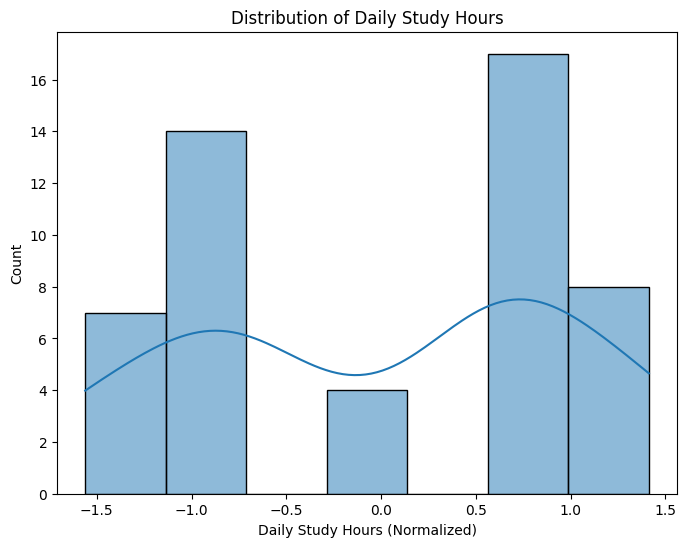

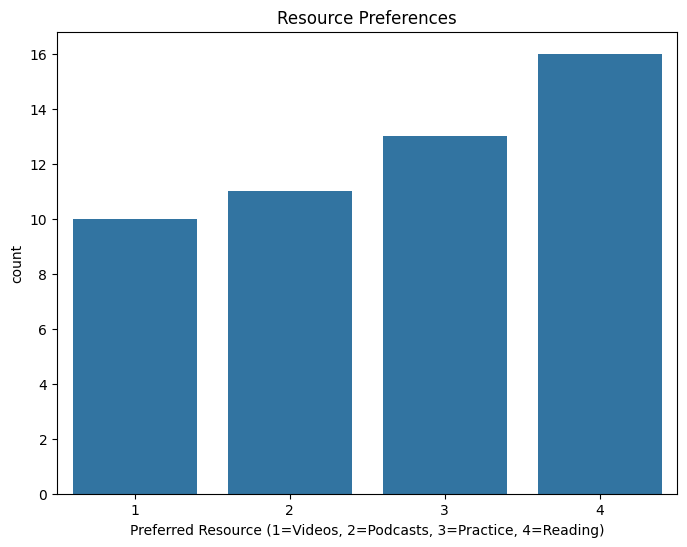

In [4]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Load processed data
data = pd.read_csv('../data/processed/processed_data.csv')

# Plot distribution of study hours
plt.figure(figsize=(8, 6))
sns.histplot(data['daily_study_hours'], kde=True)
plt.title('Distribution of Daily Study Hours')
plt.xlabel('Daily Study Hours (Normalized)')
plt.savefig('../figures/study_hours_distribution.png')
plt.show()

# Plot resource preferences
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='pref_resource')
plt.title('Resource Preferences')
plt.xlabel('Preferred Resource (1=Videos, 2=Podcasts, 3=Practice, 4=Reading)')
plt.savefig('../figures/resource_preferences.png')
plt.show()


In [5]:
import pandas as pd
import numpy as np
import os

# Debug: Print current working directory
print("Current working directory:", os.getcwd())

# Define paths
BASE_DIR = os.getcwd()
RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')

# Create directories
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Check for raw data
student_data_path = os.path.join(RAW_DIR, 'student-mat.csv')
survey_data_path = os.path.join(RAW_DIR, 'survey.csv')
if not os.path.exists(student_data_path):
    print(f"Warning: {student_data_path} not found. Generating synthetic student data.")
    student_data = pd.DataFrame({
        'studytime': np.random.randint(1, 5, size=395),
        'absences': np.random.randint(0, 21, size=395)
    })
    student_data.to_csv(student_data_path, sep=';', index=False)
    print(f"Synthetic student-mat.csv saved to {student_data_path}")
if not os.path.exists(survey_data_path):
    print(f"Warning: {survey_data_path} not found. Generating synthetic survey data.")
    np.random.seed(42)
    survey_data = pd.DataFrame({
        'pref_resource': np.random.choice([1, 2, 3, 4], size=395),
        'daily_study_hours': np.random.uniform(0.5, 10, size=395),
        'subject': np.random.choice([1, 2, 3], size=395),
        'preferred_strategy': np.random.choice([0, 1, 2, 3], size=395)
    })
    survey_data.to_csv(survey_data_path, index=False)
    print(f"Synthetic survey data saved to {survey_data_path}")

# Load data
try:
    student_data = pd.read_csv(student_data_path, sep=';')
    survey_data = pd.read_csv(survey_data_path)
    print(f"Successfully loaded {student_data_path} and {survey_data_path}")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

# Combine and process data
data = student_data[['studytime', 'absences']].copy()
data['pref_resource'] = survey_data['pref_resource']
data['daily_study_hours'] = survey_data['daily_study_hours']
data['subject'] = survey_data['subject']
data['preferred_strategy'] = survey_data['preferred_strategy']

# Save processed data
output_path = os.path.join(PROCESSED_DIR, 'processed_data.csv')
try:
    data.to_csv(output_path, index=False)
    print(f"Processed data saved to {output_path}")
except Exception as e:
    print(f"Error saving data: {str(e)}")
    raise
print(data.head())

Current working directory: C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\notebooks
Successfully loaded C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\notebooks\data\raw\student-mat.csv and C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\notebooks\data\raw\survey.csv
Processed data saved to C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\notebooks\data\processed\processed_data.csv
   studytime  absences  pref_resource  daily_study_hours  subject  \
0          3         6              3           8.635081        1   
1          4        20              4           4.342827        3   
2          2        14              1           8.933816        3   
3          2         7              3           8.583820        3   
4          4        15              3           9.388532        1   

   preferred_strategy  
0                   1  
1                   3  
2                   2  
3  

In [6]:
import pandas as pd
import numpy as np
import os

# Debug: Print current working directory
print("Current working directory:", os.getcwd())

# Define paths
BASE_DIR = os.getcwd()
RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')

# Create directories
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Check for raw data
student_data_path = os.path.join(RAW_DIR, 'student-mat.csv')
survey_data_path = os.path.join(RAW_DIR, 'survey.csv')
if not os.path.exists(student_data_path):
    print(f"Warning: {student_data_path} not found. Generating synthetic student data.")
    student_data = pd.DataFrame({
        'studytime': np.random.randint(1, 5, size=395),
        'absences': np.random.randint(0, 21, size=395)
    })
    student_data.to_csv(student_data_path, sep=';', index=False)
    print(f"Synthetic student-mat.csv saved to {student_data_path}")
if not os.path.exists(survey_data_path):
    print(f"Warning: {survey_data_path} not found. Generating synthetic survey data.")
    np.random.seed(42)
    survey_data = pd.DataFrame({
        'pref_resource': np.random.choice([1, 2, 3, 4], size=395),
        'daily_study_hours': np.random.uniform(0.5, 10, size=395),
        'subject': np.random.choice([1, 2, 3], size=395),
        'preferred_strategy': np.random.choice([0, 1, 2, 3], size=395)
    })
    survey_data.to_csv(survey_data_path, index=False)
    print(f"Synthetic survey data saved to {survey_data_path}")

# Load data
try:
    student_data = pd.read_csv(student_data_path, sep=';')
    survey_data = pd.read_csv(survey_data_path)
    print(f"Successfully loaded {student_data_path} and {survey_data_path}")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

# Combine and process data
data = student_data[['studytime', 'absences']].copy()
data['pref_resource'] = survey_data['pref_resource']
data['daily_study_hours'] = survey_data['daily_study_hours']
data['subject'] = survey_data['subject']
data['preferred_strategy'] = survey_data['preferred_strategy']

# Save processed data
output_path = os.path.join(PROCESSED_DIR, 'processed_data.csv')
try:
    data.to_csv(output_path, index=False)
    print(f"Processed data saved to {output_path}")
except Exception as e:
    print(f"Error saving data: {str(e)}")
    raise
print(data.head())

Current working directory: C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\notebooks
Successfully loaded C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\notebooks\data\raw\student-mat.csv and C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\notebooks\data\raw\survey.csv
Processed data saved to C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\notebooks\data\processed\processed_data.csv
   studytime  absences  pref_resource  daily_study_hours  subject  \
0          3         6              3           8.635081        1   
1          4        20              4           4.342827        3   
2          2        14              1           8.933816        3   
3          2         7              3           8.583820        3   
4          4        15              3           9.388532        1   

   preferred_strategy  
0                   1  
1                   3  
2                   2  
3  

Current working directory: C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\notebooks
Loading data from: C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\data\processed\data_with_clusters.csv
Successfully loaded C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\data\processed\data_with_clusters.csv
Class distribution in preferred_strategy:
preferred_strategy
3    15
2    14
1    11
0    10
Name: count, dtype: int64
Class distribution after SMOTE:
preferred_strategy
2    15
1    15
3    15
0    15
Name: count, dtype: int64
Accuracy: 0.583

Classification Report:
                   precision    recall  f1-score   support

         Pomodoro       1.00      0.33      0.50         6
    Active Recall       0.50      1.00      0.67         1
Spaced Repetition       0.50      0.67      0.57         3
      Note-Taking       0.50      1.00      0.67         2

         accuracy                           0.58        12
     

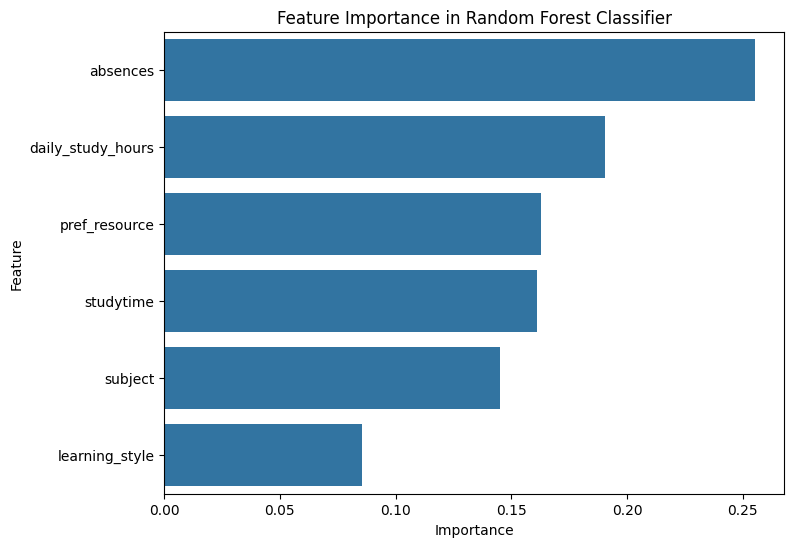

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Debug: Print current working directory
print("Current working directory:", os.getcwd())

# Define paths
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODELS_DIR = os.path.join(BASE_DIR, 'models')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Load clustered data
data_path = os.path.join(DATA_DIR, 'data_with_clusters.csv')
print(f"Loading data from: {data_path}")
try:
    data = pd.read_csv(data_path)
    print(f"Successfully loaded {data_path}")
except FileNotFoundError:
    print(f"Error: {data_path} not found. Please ensure Step 4 is complete.")
    raise

# Check class distribution
print("Class distribution in preferred_strategy:")
print(data['preferred_strategy'].value_counts())

# Define features and target
features = ['studytime', 'absences', 'pref_resource', 'daily_study_hours', 'subject', 'learning_style']
X = data[features]
y = data['preferred_strategy']

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42, k_neighbors=3)
try:
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("Class distribution after SMOTE:")
    print(pd.Series(y_resampled).value_counts())
except ValueError as e:
    print(f"SMOTE failed: {str(e)}. Proceeding without resampling.")
    X_resampled, y_resampled = X, y

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Pomodoro', 'Active Recall', 'Spaced Repetition', 'Note-Taking'], zero_division=0))

# Predict for all original data
data['predicted_strategy'] = rf.predict(X)

# Map predictions
strategy_map = {0: 'Pomodoro', 1: 'Active Recall', 2: 'Spaced Repetition', 3: 'Note-Taking'}
data['predicted_strategy_name'] = data['predicted_strategy'].map(strategy_map)

# Save Random Forest model
model_path = os.path.join(MODELS_DIR, 'random_forest.joblib')
try:
    joblib.dump(rf, model_path)
    print(f"Random Forest model saved to {model_path}")
except Exception as e:
    print(f"Error saving model: {str(e)}")
    raise

# Save data
output_path = os.path.join(DATA_DIR, 'data_with_strategies.csv')
try:
    data.to_csv(output_path, index=False)
    print(f"Data with predicted strategies saved to {output_path}")
except Exception as e:
    print(f"Error saving data: {str(e)}")
    raise
print(data[['studytime', 'pref_resource', 'daily_study_hours', 'subject', 'learning_style_name', 'predicted_strategy_name']].head())

# Feature importance plot
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Random Forest Classifier')
figure_path = os.path.join(FIGURES_DIR, 'feature_importance.png')
plt.savefig(figure_path, bbox_inches='tight')
print(f"Feature importance plot saved to {figure_path}")
plt.show()

Generating study plans...
Study plans saved to data/processed/final_study_plans.csv
  learning_style_name predicted_strategy_name       study_topic  \
0             Reading             Note-Taking           biology   
1             Reading       Spaced Repetition           history   
2         Kinesthetic           Active Recall  machine learning   
3             Reading           Active Recall           history   
4             Reading             Note-Taking           history   

                                           resources  \
0  Nature: Biology (https://www.nature.com/subjec...   
1  History.com: Topics (https://www.history.com/t...   
2  TensorFlow Playground: ML (https://playground....   
3  History.com: Topics (https://www.history.com/t...   
4  History.com: Topics (https://www.history.com/t...   

                                              advice  
0  Use Cornell Notes. Summarize key points after ...  
1  Review material at intervals. Use Quizlet (htt...  
2  Test you

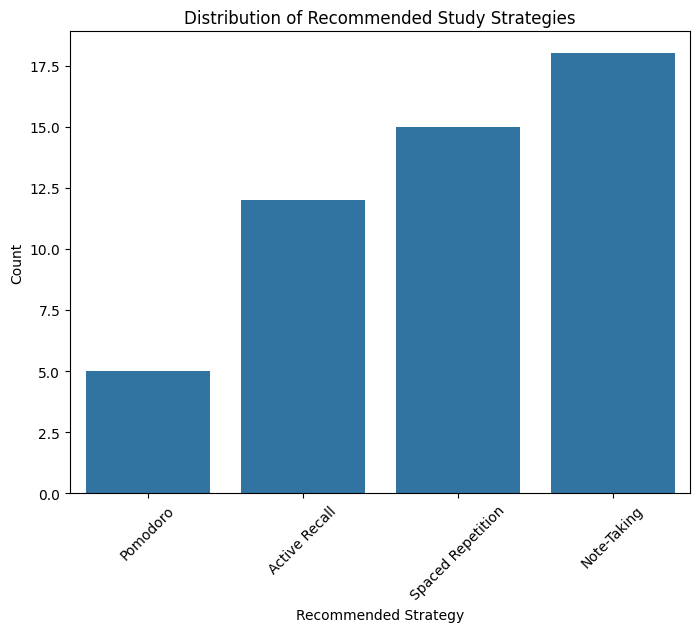

In [19]:
# Generation of study plan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
try:
    data = pd.read_csv('../data/processed/data_with_strategies.csv')
except FileNotFoundError:
    print("Error: data_with_strategies.csv not found. Please ensure Step 5 is complete.")
    raise

# Simulate user study topics
study_topics = ['calculus', 'physics', 'machine learning', 'biology', 'history']
np.random.seed(42)
data['study_topic'] = np.random.choice(study_topics, size=len(data))

# Define resource fetching function (curated links only)
def fetch_resources(learning_style, topic):
    if learning_style == 'Reading':
        topic_map = {
            'calculus': "BetterExplained: Calculus (https://betterexplained.com/articles/a-gentle-introduction-to-calculus/)",
            'physics': "Scientific American: Physics (https://www.scientificamerican.com/physics/)",
            'machine learning': "Medium: ML Basics (https://medium.com/topic/machine-learning)",
            'biology': "Nature: Biology (https://www.nature.com/subjects/biology)",
            'history': "History.com: Topics (https://www.history.com/topics)"
        }
        return topic_map.get(topic.lower(), "SparkNotes: General (https://www.sparknotes.com)")
    elif learning_style == 'Visual':
        topic_map = {
            'calculus': "Khan Academy: Calculus (https://www.khanacademy.org/math/calculus-1)",
            'physics': "CrashCourse: Physics (https://www.youtube.com/playlist?list=PL8dPuuaLjXtN0ge7yDk_UA0ldZJdhwkoV)",
            'machine learning': "freeCodeCamp: Machine Learning (https://www.youtube.com/watch?v=Eo9L-TWFZ3I)",
            'biology': "Bozeman Science: Biology (https://www.youtube.com/user/bozemanscience)",
            'history': "CrashCourse: World History (https://www.youtube.com/playlist?list=PLBDA2E52FB1EF80C9)"
        }
        return topic_map.get(topic.lower(), "Khan Academy: General (https://www.khanacademy.org)")
    elif learning_style == 'Auditory':
        topic_map = {
            'calculus': "The Math Factor: Math Topics (http://mathfactor.uark.edu)",
            'physics': "StarTalk Radio: Physics (https://www.startalkradio.net)",
            'machine learning': "Data Skeptic: Machine Learning (https://dataskeptic.com)",
            'biology': "This Week in Science: Biology (https://www.twis.org)",
            'history': "History Extra: World History (https://www.historyextra.com/podcasts)"
        }
        return topic_map.get(topic.lower(), "BBC Learning: General (https://www.bbc.co.uk/programmes/p02nrsln)")
    elif learning_style == 'Kinesthetic':
        topic_map = {
            'calculus': "GeoGebra: Calculus (https://www.geogebra.org/calculus)",
            'physics': "PhET: Physics Simulations (https://phet.colorado.edu/en/simulations/category/physics)",
            'machine learning': "TensorFlow Playground: ML (https://playground.tensorflow.org)",
            'biology': "PhET: Biology Simulations (https://phet.colorado.edu/en/simulations/category/biology)",
            'history': "Smithsonian Learning Lab: History (https://learninglab.si.edu)"
        }
        return topic_map.get(topic.lower(), "PhET: General (https://phet.colorado.edu)")
    return "No resources available"

# Generate resources and advice
print("Generating study plans...")
data['resources'] = data.apply(lambda row: fetch_resources(row['learning_style_name'], row['study_topic']), axis=1)

advice_map = {
    'Pomodoro': 'Study in 25-minute sessions with 5-minute breaks. Use Focus Booster.',
    'Active Recall': 'Test yourself with flashcards. Try Anki (https://apps.ankiweb.net).',
    'Spaced Repetition': 'Review material at intervals. Use Quizlet (https://quizlet.com).',
    'Note-Taking': 'Use Cornell Notes. Summarize key points after sessions.'
}
data['advice'] = data['predicted_strategy_name'].map(advice_map)

# Select columns
study_plans = data[['learning_style_name', 'predicted_strategy_name', 'study_topic', 'resources', 'advice']]

# Save
try:
    study_plans.to_csv('../data/processed/final_study_plans.csv', index=False)
    print("Study plans saved to data/processed/final_study_plans.csv")
except Exception as e:
    print(f"Error saving study plans: {str(e)}")
    raise

# Display sample
print(study_plans.head())

# Strategy distribution plot
plt.figure(figsize=(8, 6))
sns.countplot(data=study_plans, x='predicted_strategy_name', order=['Pomodoro', 'Active Recall', 'Spaced Repetition', 'Note-Taking'])
plt.title('Distribution of Recommended Study Strategies')
plt.xlabel('Recommended Strategy')
plt.ylabel('Count')
plt.xticks(rotation=45)
try:
    plt.savefig('../figures/strategy_distribution.png', bbox_inches='tight')
    print("Strategy distribution plot saved to figures/strategy_distribution.png")
except Exception as e:
    print(f"Error saving plot: {str(e)}")
plt.show()

In [27]:
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\samra\Documents\ML AASTU\EduFit\EduFit-Adaptive-Study-Companion\notebooks
